# **BAYESIAN OPTIMIZATION**

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from hyperopt import hp, tpe, Trials, fmin
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def objective(params, model_name, X, y):
    if model_name == 'RandomForest':
        n_estimators, max_depth = params
        model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    elif model_name == 'ANN':
        hidden_layer_sizes, alpha = params
        model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        n_neighbors = params[0]
        model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
    elif model_name == 'LogisticRegression':
        C = params[0]
        model = LogisticRegression(C=C, max_iter=1000)
    elif model_name == 'XGBoost':
        n_estimators, max_depth, learning_rate = params
        model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif model_name == 'DecisionTree':
        max_depth = params[0]
        model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
    elif model_name == 'GradientBoosting':
        n_estimators, max_depth, learning_rate = params
        model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators, learning_rate = params
        model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
    elif model_name == 'ExtraTrees':
        n_estimators, max_depth = params
        model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    elif model_name == 'Bagging':
        n_estimators = params[0]
        model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
    elif model_name == 'GaussianNB':
        model = GaussianNB()

    # CROSS VALIDATION SCORE (5FOLD)
    score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    return -score

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    with np.errstate(divide='warn'):
        imp = mu - np.max(mu_sample) - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(1, -1)

bounds_dict = {
    'RandomForest': np.array([[10, 200], [1, 20]]),
    'ANN': np.array([[10, 200], [1e-6, 1]]),
    'KNN': np.array([[1, 50]]),
    'LogisticRegression': np.array([[1e-6, 1e+2]]),
    'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
    'DecisionTree': np.array([[1, 20]]),
    'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
    'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
    'ExtraTrees': np.array([[10, 200], [1, 20]]),
    'Bagging': np.array([[10, 200]]),
}

def HPO(model_name, X, y):
    bounds = bounds_dict[model_name]
    np.random.seed(42)
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(5, bounds.shape[0]))
    Y_sample = np.array([objective(params, model_name, X, y) for params in X_sample]).reshape(-1, 1)

    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10, normalize_y=True)

    n_iterations = 20

    for i in range(n_iterations):
        gpr.fit(X_sample, Y_sample)
        next_sample = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
        next_value = objective(next_sample[0], model_name, X, y)

        X_sample = np.vstack((X_sample, next_sample))
        Y_sample = np.vstack((Y_sample, np.array(next_value).reshape(-1, 1)))

    best_index = np.argmin(Y_sample)
    best_params = X_sample[best_index]
    optimized_accuracy = -np.min(Y_sample)

    default_model = None
    if model_name == 'RandomForest':
        default_model = RandomForestClassifier(random_state=42)
    elif model_name == 'ANN':
        default_model = MLPClassifier(max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        default_model = KNeighborsClassifier()
    elif model_name == 'LogisticRegression':
        default_model = LogisticRegression(max_iter=1000)
    elif model_name == 'XGBoost':
        default_model = XGBClassifier(random_state=42)
    elif model_name == 'DecisionTree':
        default_model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'GradientBoosting':
        default_model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'AdaBoost':
        default_model = AdaBoostClassifier(random_state=42)
    elif model_name == 'ExtraTrees':
        default_model = ExtraTreesClassifier(random_state=42)
    elif model_name == 'Bagging':
        default_model = BaggingClassifier(random_state=42)
    elif model_name == 'GaussianNB':
        default_model = GaussianNB()

    default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

    if model_name == 'RandomForest':
        optimized_model = RandomForestClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), random_state=42)
    elif model_name == 'ANN':
        optimized_model = MLPClassifier(hidden_layer_sizes=(int(best_params[0]),), alpha=best_params[1], max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        optimized_model = KNeighborsClassifier(n_neighbors=int(best_params[0]))
    elif model_name == 'LogisticRegression':
        optimized_model = LogisticRegression(C=best_params[0], max_iter=1000)
    elif model_name == 'XGBoost':
        optimized_model = XGBClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
    elif model_name == 'DecisionTree':
        optimized_model = DecisionTreeClassifier(max_depth=int(best_params[0]), random_state=42)
    elif model_name == 'GradientBoosting':
        optimized_model = GradientBoostingClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
    elif model_name == 'AdaBoost':
        optimized_model = AdaBoostClassifier(n_estimators=int(best_params[0]), learning_rate=best_params[1], random_state=42)
    elif model_name == 'ExtraTrees':
        optimized_model = ExtraTreesClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), random_state=42)
    elif model_name == 'Bagging':
        optimized_model = BaggingClassifier(n_estimators=int(best_params[0]), random_state=42)
    elif model_name == 'GaussianNB':
        optimized_model = GaussianNB()

    y_pred_optimized = cross_val_predict(optimized_model, X, y, cv=5, method='predict_proba')[:, 1]
    optimized_roc_auc = roc_auc_score(y, y_pred_optimized)

    y_pred_default = cross_val_predict(default_model, X, y, cv=5, method='predict_proba')[:, 1] if default_model is not None else None
    default_roc_auc = roc_auc_score(y, y_pred_default) if y_pred_default is not None else None

    return {
        'optimized_params': best_params,
        'optimized_accuracy': optimized_accuracy,
        'default_accuracy': default_accuracy,
        'optimized_roc_auc': optimized_roc_auc,
        'default_roc_auc': default_roc_auc
    }

def optimize_model(model_name, dataset, target_column):
    data = pd.read_csv(dataset)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    results = HPO(model_name, X_preprocessed, y)

    print(f"Optimization Results for {model_name} on dataset {dataset}:")
    print(f"  Optimized Parameters: {results['optimized_params']}")
    print(f"  Optimized Accuracy: {results['optimized_accuracy']}")
    print(f"  Default Accuracy: {results['default_accuracy']}")
    print(f"  Optimized ROC-AUC: {results['optimized_roc_auc']}")
    print(f"  Default ROC-AUC: {results['default_roc_auc']}")


FINDING ACCURACY, ROC-AUC  USING HYPEROPT FOR COMAPRISON

In [2]:
def HPO_hyperopt(model_name, X, y):
    space = {
        
    'RandomForest': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'ANN': {
        'hidden_layer_sizes': hp.quniform('hidden_layer_sizes', 10, 200, 1),
        'alpha': hp.uniform('alpha', 1e-6, 1)
    },
    'KNN': {
        'n_neighbors': hp.quniform('n_neighbors', 1, 50, 1)
    },
    'LogisticRegression': {
        'C': hp.loguniform('C', np.log(1e-6), np.log(1e+2))
    },
    'XGBoost': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'DecisionTree': {
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'GradientBoosting': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'AdaBoost': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'ExtraTrees': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'Bagging': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1)
    }
}
        
    
    def objective_hyperopt(params):
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'ANN':
            model = MLPClassifier(hidden_layer_sizes=(int(params['hidden_layer_sizes']),), alpha=params['alpha'], max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=int(params['n_neighbors']))
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(C=params['C'], max_iter=1000)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier(n_estimators=int(params['n_estimators']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'ExtraTrees':
            model = ExtraTreesClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'Bagging':
            model = BaggingClassifier(n_estimators=int(params['n_estimators']), random_state=42)
        
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    trials = Trials()
    best_params = fmin(objective_hyperopt, space[model_name], algo=tpe.suggest, max_evals=20, trials=trials)

    best_params_values = {key: best_params[key] for key in space[model_name]}
    
    best_model = None
    if model_name == 'RandomForest':
        best_model = RandomForestClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'ANN':
        best_model = MLPClassifier(hidden_layer_sizes=(int(best_params_values['hidden_layer_sizes']),), alpha=best_params_values['alpha'], max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        best_model = KNeighborsClassifier(n_neighbors=int(best_params_values['n_neighbors']))
    elif model_name == 'LogisticRegression':
        best_model = LogisticRegression(C=best_params_values['C'], max_iter=1000)
    elif model_name == 'XGBoost':
        best_model = XGBClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'DecisionTree':
        best_model = DecisionTreeClassifier(max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'GradientBoosting':
        best_model = GradientBoostingClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'AdaBoost':
        best_model = AdaBoostClassifier(n_estimators=int(best_params_values['n_estimators']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'ExtraTrees':
        best_model = ExtraTreesClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'Bagging':
        best_model = BaggingClassifier(n_estimators=int(best_params_values['n_estimators']), random_state=42)

    best_model.fit(X, y)
    
    return best_params_values, best_model

def optimize_model_hyperopt(model_name, dataset, target_column):
    data = pd.read_csv(dataset)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    best_params_hyperopt, best_model_hyperopt = HPO_hyperopt(model_name, X_preprocessed, y)

    cross_val_scores_hyperopt = cross_val_score(best_model_hyperopt, X_preprocessed, y, cv=5, scoring='accuracy').mean()

    y_pred_hyperopt = cross_val_predict(best_model_hyperopt, X_preprocessed, y, cv=5, method='predict_proba')[:, 1]
    roc_auc_hyperopt = roc_auc_score(y, y_pred_hyperopt)

    print(f"Optimization Results for {model_name} using Hyperopt on dataset {dataset}:")
    print(f"  Optimized Parameters-Hyperopt: {best_params_hyperopt}")
    print(f"  Accuracy - Hyperopt: {cross_val_scores_hyperopt}")
    print(f"  ROC-AUC Score - Hyperopt: {roc_auc_hyperopt}")




TESTING BAYESIAN OPTIMIZATION AND COMAPIRNG RESULTS WITH HYPEROPT ON VARIOUS ML MODELS

KNN

In [3]:

optimize_model('KNN', 'mushrooms.csv', 'class')
optimize_model_hyperopt('KNN', 'mushrooms.csv', 'class')


Optimization Results for KNN on dataset mushrooms.csv:
  Optimized Parameters: [2.68503753]
  Optimized Accuracy: 0.9545764304660856
  Default Accuracy: 0.9278522925350512
  Optimized ROC-AUC: 0.9545157188797445
  Default ROC-AUC: 0.9634846025081854
100%|██████████| 20/20 [00:39<00:00,  2.00s/trial, best loss: -0.9545764304660856]
Optimization Results for KNN using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_neighbors': 2.0}
  Accuracy - Hyperopt: 0.9545764304660856
  ROC-AUC Score - Hyperopt: 0.9545157188797445


ANN

In [4]:

optimize_model('ANN', 'mushrooms.csv', 'class')
optimize_model_hyperopt('ANN', 'mushrooms.csv', 'class')


Optimization Results for ANN on dataset mushrooms.csv:
  Optimized Parameters: [74.80262041  0.11347632]
  Optimized Accuracy: 0.9256250852595681
  Default Accuracy: 0.9112213717317166
  Optimized ROC-AUC: 0.9889450683944586
  Default ROC-AUC: 0.9865433368805758
100%|██████████| 20/20 [10:17<00:00, 30.88s/trial, best loss: -0.9272273588480486]
Optimization Results for ANN using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'hidden_layer_sizes': 161.0, 'alpha': 0.10895965572579443}
  Accuracy - Hyperopt: 0.9272273588480486
  ROC-AUC Score - Hyperopt: 0.989573158476291


LOGISTIC REGRESSION

In [5]:

optimize_model('LogisticRegression', 'mushrooms.csv', 'class')
optimize_model_hyperopt('LogisticRegression', 'mushrooms.csv', 'class')


Optimization Results for LogisticRegression on dataset mushrooms.csv:
  Optimized Parameters: [95.07143069]
  Optimized Accuracy: 0.9423687760515348
  Default Accuracy: 0.9193427813565744
  Optimized ROC-AUC: 0.9914817027346132
  Default ROC-AUC: 0.9866770260062063
100%|██████████| 20/20 [00:01<00:00, 14.26trial/s, best loss: -0.941137400530504] 
Optimization Results for LogisticRegression using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'C': 55.77420763063552}
  Accuracy - Hyperopt: 0.941137400530504
  ROC-AUC Score - Hyperopt: 0.9912901807734283


RANDOM FOREST

In [6]:


optimize_model('RandomForest', 'mushrooms.csv', 'class')
optimize_model_hyperopt('RandomForest', 'mushrooms.csv', 'class')


/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimization Results for RandomForest on dataset mushrooms.csv:
  Optimized Parameters: [41.21050161 16.47691968]
  Optimized Accuracy: 0.9359802197802198
  Default Accuracy: 0.9315465706707086
  Optimized ROC-AUC: 0.9885769226474598
  Default ROC-AUC: 0.9880208656986837
100%|██████████| 20/20 [00:16<00:00,  1.23trial/s, best loss: -0.9418915498294809]
Optimization Results for RandomForest using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 36.0, 'max_depth': 9.0}
  Accuracy - Hyperopt: 0.9418915498294809
  ROC-AUC Score - Hyperopt: 0.9876716536816881


XGBOOST

In [7]:

optimize_model('XGBoost', 'mushrooms.csv', 'class')
optimize_model_hyperopt('XGBoost', 'mushrooms.csv', 'class')


Optimization Results for XGBoost on dataset mushrooms.csv:
  Optimized Parameters: [198.11023152   3.66159629   0.26398153]
  Optimized Accuracy: 0.9731531640773021
  Default Accuracy: 0.9602221295945433
  Optimized ROC-AUC: 0.9997363842207265
  Default ROC-AUC: 0.9956984021873798
100%|██████████| 20/20 [00:03<00:00,  6.21trial/s, best loss: -0.9768579765062524]
Optimization Results for XGBoost using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 44.0, 'max_depth': 1.0, 'learning_rate': 0.25989111268778525}
  Accuracy - Hyperopt: 0.9768579765062524
  ROC-AUC Score - Hyperopt: 0.9834300733657764


DECISION TREE

In [8]:

optimize_model('DecisionTree', 'mushrooms.csv', 'class')
optimize_model_hyperopt('DecisionTree', 'mushrooms.csv', 'class')


Optimization Results for DecisionTree on dataset mushrooms.csv:
  Optimized Parameters: [8.11626226]
  Optimized Accuracy: 0.996182796513831
  Default Accuracy: 0.996182796513831
  Optimized ROC-AUC: 0.9962545198211878
  Default ROC-AUC: 0.9962545198211878
100%|██████████| 20/20 [00:00<00:00, 29.20trial/s, best loss: -0.996182796513831]
Optimization Results for DecisionTree using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'max_depth': 13.0}
  Accuracy - Hyperopt: 0.996182796513831
  ROC-AUC Score - Hyperopt: 0.9962545198211878


GRADIENT BOOSTING

In [9]:

optimize_model('GradientBoosting', 'mushrooms.csv', 'class')
optimize_model_hyperopt('GradientBoosting', 'mushrooms.csv', 'class')


/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/

Optimization Results for GradientBoosting on dataset mushrooms.csv:
  Optimized Parameters: [111.19199218   1.9846472    0.1749361 ]
  Optimized Accuracy: 0.9970461538461539
  Default Accuracy: 0.9507389162561577
  Optimized ROC-AUC: 0.9982974814255253
  Default ROC-AUC: 0.9998657647090808
100%|██████████| 20/20 [00:50<00:00,  2.53s/trial, best loss: -0.9963058734369079]
Optimization Results for GradientBoosting using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 119.0, 'max_depth': 15.0, 'learning_rate': 0.4182710101755799}
  Accuracy - Hyperopt: 0.9963058734369079
  ROC-AUC Score - Hyperopt: 0.9995088153504973


ADA BOOST

In [10]:


optimize_model('AdaBoost', 'mushrooms.csv', 'class')
optimize_model_hyperopt('AdaBoost', 'mushrooms.csv', 'class')


/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimization Results for AdaBoost on dataset mushrooms.csv:
  Optimized Parameters: [39.64354168  0.08643731]
  Optimized Accuracy: 0.9545701402046228
  Default Accuracy: 0.9288359226979918
  Optimized ROC-AUC: 0.9865657599999222
  Default ROC-AUC: 0.9886202214178353
100%|██████████| 20/20 [01:14<00:00,  3.74s/trial, best loss: -0.9538316786661614]
Optimization Results for AdaBoost using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 27.0, 'learning_rate': 0.12446762851276114}
  Accuracy - Hyperopt: 0.9538316786661614
  ROC-AUC Score - Hyperopt: 0.9893125769486206


EXTRA TREES

In [11]:

optimize_model('ExtraTrees', 'mushrooms.csv', 'class')
optimize_model_hyperopt('ExtraTrees', 'mushrooms.csv', 'class')


Optimization Results for ExtraTrees on dataset mushrooms.csv:
  Optimized Parameters: [149.07884894  12.3745112 ]
  Optimized Accuracy: 0.9379504357711255
  Default Accuracy: 0.931792800303145
  Optimized ROC-AUC: 0.9907428321267531
  Default ROC-AUC: 0.9898015769369691
100%|██████████| 20/20 [00:22<00:00,  1.12s/trial, best loss: -0.9372168245547556]
Optimization Results for ExtraTrees using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 98.0, 'max_depth': 6.0}
  Accuracy - Hyperopt: 0.9372168245547556
  ROC-AUC Score - Hyperopt: 0.9898655389607616


BAGGING

In [12]:

optimize_model('Bagging', 'mushrooms.csv', 'class')
optimize_model_hyperopt('Bagging', 'mushrooms.csv', 'class')


/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimization Results for Bagging on dataset mushrooms.csv:
  Optimized Parameters: [27.34446859]
  Optimized Accuracy: 0.9433502084122773
  Default Accuracy: 0.9407640773020084
  Optimized ROC-AUC: 0.999053738295071
  Default ROC-AUC: 0.9984075337311682
100%|██████████| 20/20 [01:02<00:00,  3.12s/trial, best loss: -0.9418723758999621]
Optimization Results for Bagging using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 24.0}
  Accuracy - Hyperopt: 0.9418723758999621
  ROC-AUC Score - Hyperopt: 0.9988059613091654


PLOTTING LEARNING RATE DISTRIBUTION CURVES

In [13]:
def PLOT(model_name,dataset,target):

    import numpy as np
    from scipy.optimize import minimize
    from scipy.stats import norm
    from sklearn.model_selection import cross_val_score,cross_val_predict
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from hyperopt import hp, tpe, Trials, fmin
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt

   


    def objective(params, model_name, X, y):
        if model_name == 'RandomForest':
            n_estimators, max_depth = params
            model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'ANN':
            hidden_layer_sizes, alpha = params
            model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            n_neighbors = params[0]
            model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
        elif model_name == 'LogisticRegression':
            C = params[0]
            model = LogisticRegression(C=C, max_iter=1000)
        elif model_name == 'XGBoost':
            n_estimators, max_depth, learning_rate = params
            model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'DecisionTree':
            max_depth = params[0]
            model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
        elif model_name == 'GradientBoosting':
            n_estimators, max_depth, learning_rate = params
            model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'AdaBoost':
            n_estimators, learning_rate = params
            model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
        elif model_name == 'ExtraTrees':
            n_estimators, max_depth = params
            model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'Bagging':
            n_estimators = params[0]
            model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
        elif model_name == 'GaussianNB':
            model = GaussianNB()
    
    # CROSS VALIDATION SCORE (5FOLD)
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
        mu, sigma = gpr.predict(X, return_std=True)
        mu_sample = gpr.predict(X_sample)

        sigma = sigma.reshape(-1, 1)
        with np.errstate(divide='warn'):
            imp = mu - np.max(mu_sample) - xi
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0

        return ei

    def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
        dim = X_sample.shape[1]
        min_val = 1
        min_x = None

        def min_obj(X):
            return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

        for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
            res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
            if res.fun < min_val:
                min_val = res.fun
                min_x = res.x

        return min_x.reshape(1, -1)

    bounds_dict = {
        'RandomForest': np.array([[10, 200], [1, 20]]),
        'ANN': np.array([[10, 200], [1e-6, 1]]),
        'KNN': np.array([[1, 50]]),
        'LogisticRegression': np.array([[1e-6, 1e+2]]),
        'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'DecisionTree': np.array([[1, 20]]),
        'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
        'ExtraTrees': np.array([[10, 200], [1, 20]]),
        'Bagging': np.array([[10, 200]]),
    }

    def HPO(model_name, X, y):
        bounds = bounds_dict[model_name]
        np.random.seed(42)
        X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(5, bounds.shape[0]))
        Y_sample = np.array([objective(params, model_name, X, y) for params in X_sample]).reshape(-1, 1)

        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10, normalize_y=True)

        n_iterations = 20

        learning_rates = []  
        accuracies = [] 

        for i in range(n_iterations):
            gpr.fit(X_sample, Y_sample)
            next_sample = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
            next_value = objective(next_sample[0], model_name, X, y)

            learning_rate = None
            if model_name == 'XGBoost' or model_name == 'GradientBoosting':
                learning_rate = next_sample[0][-1] 
                learning_rates.append(learning_rate)

                if model_name == 'XGBoost':
                    model = XGBClassifier(n_estimators=int(next_sample[0][0]), max_depth=int(next_sample[0][1]),
                                        learning_rate=learning_rate, random_state=42)
                elif model_name == 'GradientBoosting':
                    model = GradientBoostingClassifier(n_estimators=int(next_sample[0][0]), max_depth=int(next_sample[0][1]),
                                                        learning_rate=learning_rate, random_state=42)
                accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
                accuracies.append(accuracy)

            X_sample = np.vstack((X_sample, next_sample))
            Y_sample = np.vstack((Y_sample, np.array(next_value).reshape(-1, 1)))

        best_index = np.argmin(Y_sample)
        best_params = X_sample[best_index]
        optimized_accuracy = -np.min(Y_sample)
        
        
        default_model = None
        if model_name == 'RandomForest':
            default_model = RandomForestClassifier(random_state=42)
        elif model_name == 'ANN':
            default_model = MLPClassifier(max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            default_model = KNeighborsClassifier()
        elif model_name == 'LogisticRegression':
            default_model =LogisticRegression(max_iter=1000)
        elif model_name == 'XGBoost':
            default_model = XGBClassifier(random_state=42)
        elif model_name == 'DecisionTree':
            default_model = DecisionTreeClassifier(random_state=42)
        elif model_name == 'GradientBoosting':
            default_model = GradientBoostingClassifier(random_state=42)
        elif model_name == 'AdaBoost':
            default_model = AdaBoostClassifier(random_state=42)
        elif model_name == 'ExtraTrees':
            default_model = ExtraTreesClassifier(random_state=42)
        elif model_name == 'Bagging':
            default_model = BaggingClassifier(random_state=42)
        elif model_name == 'GaussianNB':
            default_model = GaussianNB()
        
        default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

        return {
            'optimized_params': best_params,
            'optimized_accuracy': optimized_accuracy,
            'default_accuracy': default_accuracy,
            'learning_rates': learning_rates,
            'accuracies': accuracies
        }
    
    def plot_learning_rate_accuracy(learning_rates, accuracies):
        iterations = range(1, len(learning_rates) + 1)
        plt.plot(iterations, learning_rates, marker='o', label='Learning Rate')
        plt.plot(iterations, accuracies, marker='x', label='Accuracy')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Learning Rate and Accuracy vs Iteration')
        plt.legend()
        plt.grid(True)
        plt.show()

    



    def optimize_model(model_name, dataset, target_column):
        data = pd.read_csv(dataset)
        X = data.drop(columns=[target_column])
        y = data[target_column]

        le = LabelEncoder()
        y = le.fit_transform(y)

        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        numerical_cols = X.select_dtypes(include=['number']).columns

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        X_preprocessed = preprocessor.fit_transform(X)

        results = HPO(model_name, X_preprocessed, y)
        plot_learning_rate_accuracy(results['learning_rates'], results['accuracies'])

    optimize_model(model_name, dataset, target)





LEARNING RATE DISTRIBUTION CURVE -> XGBOOST

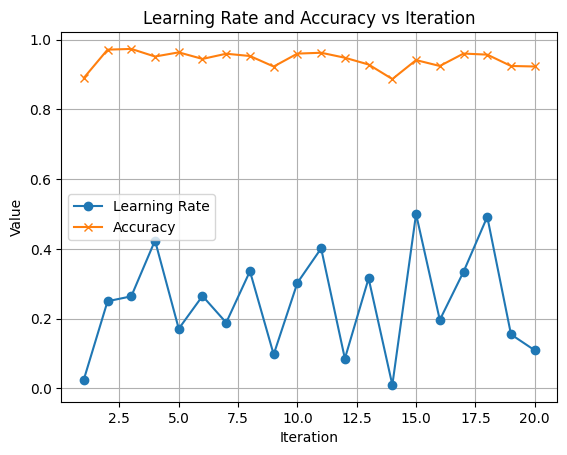

In [14]:
PLOT('XGBoost','mushrooms.csv','class')

LEARNING RATE DISTRIBUTION CURVE -> GRADIENT BOOSTING

/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/

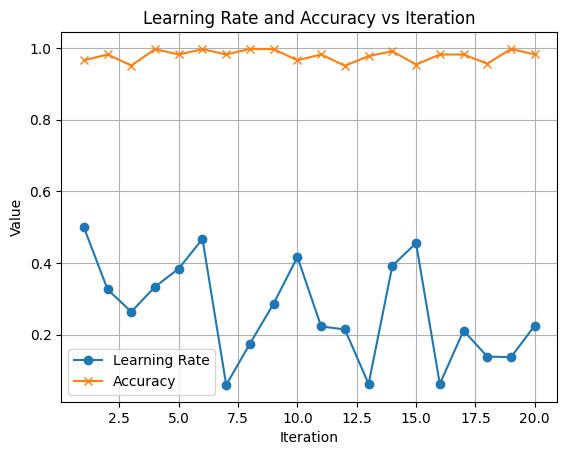

In [15]:
PLOT('GradientBoosting','mushrooms.csv','class')

PLOTTING LEARNING RATE DISTRIBUTION CURVE FOR HYPEROPT  FOR COMPARISON

100%|██████████| 20/20 [00:49<00:00,  2.47s/trial, best loss: -0.9963058734369079]


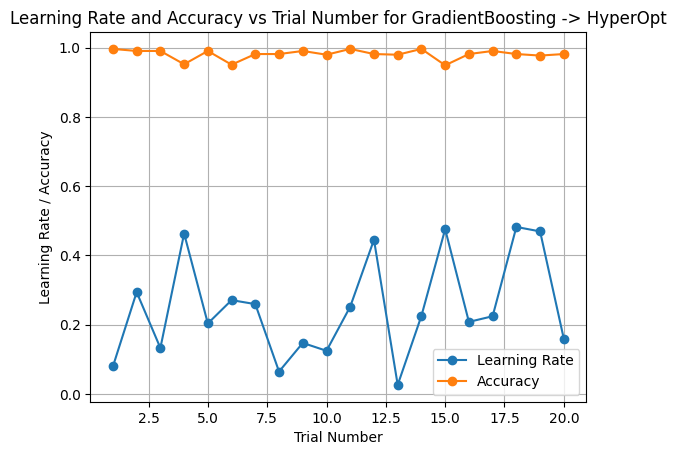

100%|██████████| 20/20 [00:04<00:00,  4.13trial/s, best loss: -0.97069010989011] 


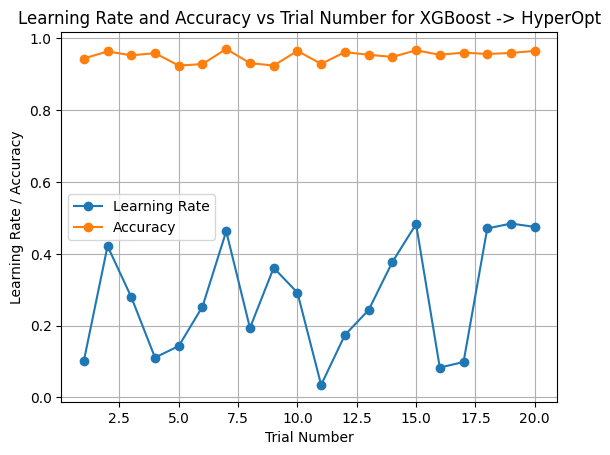

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from hyperopt import hp, tpe, Trials, fmin

def HPO_hyperopt(model_name, X, y):
    space = {
        'RandomForest': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1)
        },
        'ANN': {
            'hidden_layer_sizes': hp.quniform('hidden_layer_sizes', 10, 200, 1),
            'alpha': hp.uniform('alpha', 1e-6, 1)
        },
        'KNN': {
            'n_neighbors': hp.quniform('n_neighbors', 1, 50, 1)
        },
        'LogisticRegression': {
            'C': hp.loguniform('C', np.log(1e-6), np.log(1e+2))
        },
        'XGBoost': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
        },
        'DecisionTree': {
            'max_depth': hp.quniform('max_depth', 1, 20, 1)
        },
        'GradientBoosting': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
        },
        'AdaBoost': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
        },
        'ExtraTrees': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1)
        },
        'Bagging': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1)
        }
    }
    
    learning_rates = []  
    accuracies = []     
    
    def objective_hyperopt(params):
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'ANN':
            model = MLPClassifier(hidden_layer_sizes=(int(params['hidden_layer_sizes']),), alpha=params['alpha'], max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=int(params['n_neighbors']))
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(C=params['C'], max_iter=1000)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier(n_estimators=int(params['n_estimators']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'ExtraTrees':
            model = ExtraTreesClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'Bagging':
            model = BaggingClassifier(n_estimators=int(params['n_estimators']), random_state=42)
        
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        
        if 'learning_rate' in params:
            learning_rates.append(params['learning_rate'])
            accuracies.append(score)
        
        return -score

    trials = Trials()
    best_params = fmin(objective_hyperopt, space[model_name], algo=tpe.suggest, max_evals=20, trials=trials)

    best_params_values = [best_params[key] for key in space[model_name]]
    best_score = -trials.best_trial['result']['loss']

    return best_params_values, best_score, learning_rates, accuracies

def optimize_model_hyperopt(model_name, dataset, target_column):
    data = pd.read_csv(dataset)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    best_params_hyperopt, best_score_hyperopt, learning_rates, accuracies = HPO_hyperopt(model_name, X_preprocessed, y)


    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rate', marker='o')
    plt.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy', marker='o')
    plt.title(f"Learning Rate and Accuracy vs Trial Number for {model_name} -> HyperOpt")
    plt.xlabel("Trial Number")
    plt.ylabel("Learning Rate / Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

optimize_model_hyperopt('GradientBoosting', 'mushrooms.csv', 'class')
optimize_model_hyperopt('XGBoost', 'mushrooms.csv', 'class')




## Learning Rate Curve for GradientBoosting Bayesian vs HyperOpt

<img src="gradientBayesian.png" alt="Bayesian Optimization" style="width: 45%; float: left; margin-right: 5%;">
<img src="gradientHyperOpt.png" alt="HyperOpt Optimization" style="width: 45%; float: left;">



## Learning Rate Curve for XGBoost Bayesian vs HyperOpt

<img src="xgBayesian.png" alt="Bayesian Optimization" style="width: 45%; float: left; margin-right: 5%;">
<img src="xgHyperOpt.png" alt="HyperOpt Optimization" style="width: 45%; float: left;">



PLOTTING HISTOGRAM OF LEARNING RATE VS DENSITY FOR HYPEROPT

100%|██████████| 20/20 [00:38<00:00,  1.92s/trial, best loss: -0.9963058734369079]


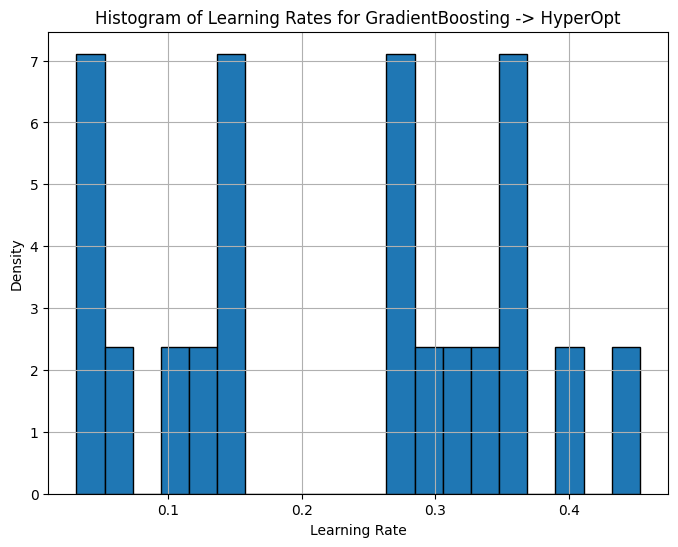

100%|██████████| 20/20 [00:03<00:00,  5.08trial/s, best loss: -0.973522773777946]


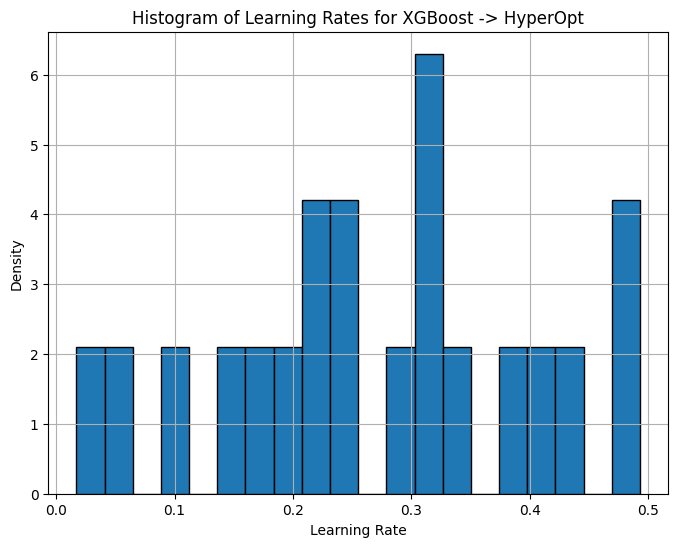

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from hyperopt import hp, tpe, Trials, fmin

def HPO_hyperopt(model_name, X, y):
    space = {
        'RandomForest': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1)
        },
        'ANN': {
            'hidden_layer_sizes': hp.quniform('hidden_layer_sizes', 10, 200, 1),
            'alpha': hp.uniform('alpha', 1e-6, 1)
        },
        'KNN': {
            'n_neighbors': hp.quniform('n_neighbors', 1, 50, 1)
        },
        'LogisticRegression': {
            'C': hp.loguniform('C', np.log(1e-6), np.log(1e+2))
        },
        'XGBoost': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
        },
        'DecisionTree': {
            'max_depth': hp.quniform('max_depth', 1, 20, 1)
        },
        'GradientBoosting': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
        },
        'AdaBoost': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
        },
        'ExtraTrees': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1)
        },
        'Bagging': {
            'n_estimators': hp.quniform('n_estimators', 10, 200, 1)
        }
    }
    
    learning_rates = []  
    accuracies = []     
    
    def objective_hyperopt(params):
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'ANN':
            model = MLPClassifier(hidden_layer_sizes=(int(params['hidden_layer_sizes']),), alpha=params['alpha'], max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=int(params['n_neighbors']))
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(C=params['C'], max_iter=1000)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier(n_estimators=int(params['n_estimators']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'ExtraTrees':
            model = ExtraTreesClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'Bagging':
            model = BaggingClassifier(n_estimators=int(params['n_estimators']), random_state=42)
        
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        
        if 'learning_rate' in params:
            learning_rates.append(params['learning_rate'])
            accuracies.append(score)
        
        return -score

    trials = Trials()
    best_params = fmin(objective_hyperopt, space[model_name], algo=tpe.suggest, max_evals=20, trials=trials)

    best_params_values = [best_params[key] for key in space[model_name]]
    best_score = -trials.best_trial['result']['loss']

    return best_params_values, best_score, learning_rates, accuracies

def optimize_model_hyperopt(model_name, dataset, target_column):
    data = pd.read_csv(dataset)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    best_params_hyperopt, best_score_hyperopt, learning_rates, accuracies = HPO_hyperopt(model_name, X_preprocessed, y)

    # Plotting histogram of learning rates
    plt.figure(figsize=(8, 6))
    plt.hist(learning_rates, bins=20, edgecolor='black', density=True)
    plt.title(f"Histogram of Learning Rates for {model_name} -> HyperOpt")
    plt.xlabel("Learning Rate")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

optimize_model_hyperopt('GradientBoosting', 'mushrooms.csv', 'class')
optimize_model_hyperopt('XGBoost', 'mushrooms.csv', 'class')


PLOTTING HISTOGRAM OF LEARNING RATE VS DENSITY FOR BAYESIAN

In [1]:
def PLOT_HIST(model_name, dataset, target):
    import numpy as np
    from scipy.optimize import minimize
    from scipy.stats import norm
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from hyperopt import hp, tpe, Trials, fmin
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt

    def objective(params, model_name, X, y):
        if model_name == 'RandomForest':
            n_estimators, max_depth = params
            model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'ANN':
            hidden_layer_sizes, alpha = params
            model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            n_neighbors = params[0]
            model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
        elif model_name == 'LogisticRegression':
            C = params[0]
            model = LogisticRegression(C=C, max_iter=1000)
        elif model_name == 'XGBoost':
            n_estimators, max_depth, learning_rate = params
            model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'DecisionTree':
            max_depth = params[0]
            model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
        elif model_name == 'GradientBoosting':
            n_estimators, max_depth, learning_rate = params
            model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'AdaBoost':
            n_estimators, learning_rate = params
            model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
        elif model_name == 'ExtraTrees':
            n_estimators, max_depth = params
            model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'Bagging':
            n_estimators = params[0]
            model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
        elif model_name == 'GaussianNB':
            model = GaussianNB()
    
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
        mu, sigma = gpr.predict(X, return_std=True)
        mu_sample = gpr.predict(X_sample)

        sigma = sigma.reshape(-1, 1)
        with np.errstate(divide='warn'):
            imp = mu - np.max(mu_sample) - xi
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0

        return ei

    def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
        dim = X_sample.shape[1]
        min_val = 1
        min_x = None

        def min_obj(X):
            return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

        for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
            res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
            if res.fun < min_val:
                min_val = res.fun
                min_x = res.x

        return min_x.reshape(1, -1)

    bounds_dict = {
        'RandomForest': np.array([[10, 200], [1, 20]]),
        'ANN': np.array([[10, 200], [1e-6, 1]]),
        'KNN': np.array([[1, 50]]),
        'LogisticRegression': np.array([[1e-6, 1e+2]]),
        'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'DecisionTree': np.array([[1, 20]]),
        'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
        'ExtraTrees': np.array([[10, 200], [1, 20]]),
        'Bagging': np.array([[10, 200]]),
    }

    def HPO(model_name, X, y):
        bounds = bounds_dict[model_name]
        np.random.seed(42)
        X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(5, bounds.shape[0]))
        Y_sample = np.array([objective(params, model_name, X, y) for params in X_sample]).reshape(-1, 1)

        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10, normalize_y=True)

        n_iterations = 20

        learning_rates = []  
        accuracies = [] 

        for i in range(n_iterations):
            gpr.fit(X_sample, Y_sample)
            next_sample = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
            next_value = objective(next_sample[0], model_name, X, y)

            learning_rate = None
            if model_name == 'XGBoost' or model_name == 'GradientBoosting':
                learning_rate = next_sample[0][-1] 
                learning_rates.append(learning_rate)

                if model_name == 'XGBoost':
                    model = XGBClassifier(n_estimators=int(next_sample[0][0]), max_depth=int(next_sample[0][1]),
                                        learning_rate=learning_rate, random_state=42)
                elif model_name == 'GradientBoosting':
                    model = GradientBoostingClassifier(n_estimators=int(next_sample[0][0]), max_depth=int(next_sample[0][1]),
                                                        learning_rate=learning_rate, random_state=42)
                accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
                accuracies.append(accuracy)

            X_sample = np.vstack((X_sample, next_sample))
            Y_sample = np.vstack((Y_sample, np.array(next_value).reshape(-1, 1)))

        best_index = np.argmin(Y_sample)
        best_params = X_sample[best_index]
        optimized_accuracy = -np.min(Y_sample)
        
        default_model = None
        if model_name == 'RandomForest':
            default_model = RandomForestClassifier(random_state=42)
        elif model_name == 'ANN':
            default_model = MLPClassifier(max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            default_model = KNeighborsClassifier()
        elif model_name == 'LogisticRegression':
            default_model =LogisticRegression(max_iter=1000)
        elif model_name == 'XGBoost':
            default_model = XGBClassifier(random_state=42)
        elif model_name == 'DecisionTree':
            default_model = DecisionTreeClassifier(random_state=42)
        elif model_name == 'GradientBoosting':
            default_model = GradientBoostingClassifier(random_state=42)
        elif model_name == 'AdaBoost':
            default_model = AdaBoostClassifier(random_state=42)
        elif model_name == 'ExtraTrees':
            default_model = ExtraTreesClassifier(random_state=42)
        elif model_name == 'Bagging':
            default_model = BaggingClassifier(random_state=42)
        elif model_name == 'GaussianNB':
            default_model = GaussianNB()
        
        default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

        return {
            'optimized_params': best_params,
            'optimized_accuracy': optimized_accuracy,
            'default_accuracy': default_accuracy,
            'learning_rates': learning_rates,
            'accuracies': accuracies
        }

    def plot_learning_rate_histogram(learning_rates):
        plt.hist(learning_rates, bins=10, edgecolor='black', density=True)
        plt.xlabel('Learning Rate')
        plt.ylabel('Density')
        plt.title('Histogram of Learning Rates')
        plt.grid(True)
        plt.show()
    
    def optimize_model(model_name, dataset, target_column):
        data = pd.read_csv(dataset)
        X = data.drop(columns=[target_column])
        y = data[target_column]

        le = LabelEncoder()
        y = le.fit_transform(y)

        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        numerical_cols = X.select_dtypes(include=['number']).columns

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        X_preprocessed = preprocessor.fit_transform(X)

        results = HPO(model_name, X_preprocessed, y)
        plot_learning_rate_histogram(results['learning_rates'])

    optimize_model(model_name, dataset, target)



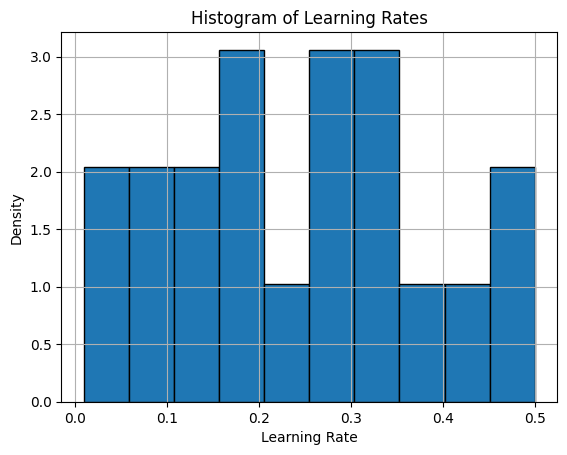

In [2]:
PLOT_HIST('XGBoost','mushrooms.csv','class')

/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/aryanlaroia/.pyenv/versions/3.8.19/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/

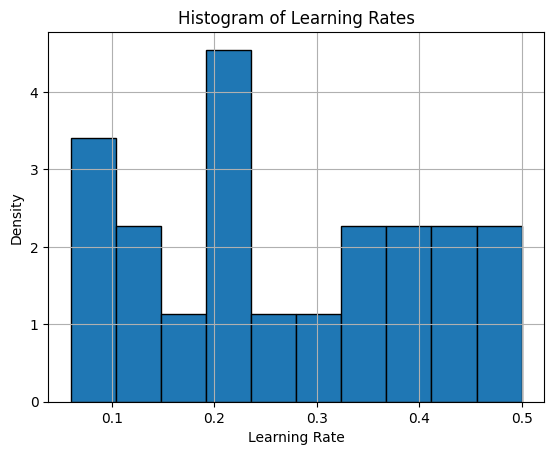

In [3]:
PLOT_HIST('GradientBoosting','mushrooms.csv','class')